#Related Env: prs

In [183]:
from pyraysum import prs, Geometry, Model, Control
import numpy as np
import os
import obspy as op
import pandas as pd
from numpy.linalg import norm
from scipy.optimize import dual_annealing, rosen, shgo, differential_evolution
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import LinearConstraint, Bounds
import ast

In [184]:
def read_layers(layers=2, **kwargs) -> pd.DataFrame:
    models = pd.read_csv("inv/initial/all_layers.csv")
    models = models[models["layer_code"] == layers]
    selected_model = models[["thickn", "rho", "vp", "vs", "dip", "strike", "plunge", "trend", "ani"]]
   
    # bounds
    bounds_from_file = pd.read_csv("inv/initial/bounds.csv")
    df = bounds_from_file[bounds_from_file["layer_code"] == layers]
    df = df.drop(columns=["layer_code"])
    bounds = []
    for key in df.keys():
        for row in df[key]:
            each_bound = ast.literal_eval(row) #turn string to tuple
            each_bound = (float(each_bound[0]), int(each_bound[1]))
            bounds.append(ast.literal_eval(row))
    bounds = [i for i in bounds if i != (0, 0)]
    return selected_model.reset_index(), bounds

def cal_snr_for_transverse(rft: np.array) -> np.array:
    """
    Calculate the signal to noise based on closest 100 samples to P-wave (centered at 213th sample)
    """
    noise = rft[:213]
    signal = rft[213:]
    return np.sum(np.square(signal)) / np.sum(np.square(noise))


def reading_rfs(keyword: str, t_snr_treshold=0) -> list:
    """
    Reading RF data by the name of keyword as station code
    inputs:
    keyword: str
        station code
    t_snr_treshold: float
        signal to noise ratio treshold for transverse component (default 0, means no treshold)

    outputs:
    obser: np.array
        observed data in numpy array format
    baz: list
        corresponding back azimuth
    slow: list
        corresponding slowness
    """
    baz = []
    slow = []
    waveforms_list = pd.read_csv("DATA/waveforms_list.csv")
    filtered_files = waveforms_list[waveforms_list['sta_code']==keyword].copy()
    filtered_files = filtered_files[filtered_files['rf_quality'] == 1].copy()
    path = "DATA/RF/"
    npts = 426 * 2   
    dt = 0.2
    obser = np.zeros((len(filtered_files), npts))

    idx = 0
    for _, row in filtered_files.iterrows():
        wave_path = os.path.join(path, row['file_name']+".pkl")
        st = op.read(wave_path)
        RFR = st.select(channel="RFR")[0].filter('bandpass', freqmin=0.05, freqmax=0.3, corners=2, zerophase=True).data
        RFT = st.select(channel="RFT")[0].filter('bandpass', freqmin=0.05, freqmax=0.3, corners=2, zerophase=True).data
        #check if the signal to noise ratio is above the treshold
        if cal_snr_for_transverse(RFT) > t_snr_treshold:
            baz.append(st[0].stats.baz)
            slow.append(st[0].stats.slow)
            max_val = max(np.max(np.abs(RFR)), np.max(np.abs(RFT)))
            RFR = RFR/max_val
            RFT = RFT/max_val
            obser[idx, :426] = RFR
            obser[idx, 426:] = RFT
            idx += 1
    obser = obser[:idx, :]
    return obser, baz, slow


def pyraysum_func(baz, slow, thickn, rho, vp, vs, dip, strike, plunge, trend, ani, npts, dt) -> tuple:
    model = Model(thickn, rho, vp, vs=vs, strike=strike, dip=dip, plunge=plunge, trend=trend, ani=ani)
    geom = Geometry(baz, slow)
    rc = Control(wvtype="P", rot="RTZ", mults=2, verbose=False, npts=npts*1, dt=dt, align=1, shift=5)
    result = prs.run(model, geom, rc, rf=True)
    result.filter('rfs', 'lowpass', freq=1., zerophase=True, corners=2)
    return model, geom, result


def predict(geom, model):
    model, _, result = pyraysum_func(geom["baz"], geom["slow"], model["thickn"], model["rho"], model["vp"], model["vs"], model["dip"],
                                     model["strike"], model["plunge"], model["trend"], model["ani"], 3*426, 0.2)
    #lower number of samples would be problematic and that is why we produce longer signal and then reduce it
    pred = np.zeros((len(result), 2*426)) 
    pred_r = np.zeros((len(result), 3*426))
    pred_t = np.zeros((len(result), 3*426))

    for idx, i in enumerate(result):
        RFR = i[1][0].filter('bandpass', freqmin=0.05, freqmax=0.3, corners=2, zerophase=True).data
        RFT = i[1][1].filter('bandpass', freqmin=0.05, freqmax=0.3, corners=2, zerophase=True).data
        max_val = max(np.max(np.abs(RFR)), np.max(np.abs(RFT)))
        pred_r[idx, :] = RFR/max_val
        pred_t[idx, :] = RFT/max_val
    pred_r = pred_r[:, 426:2*426]
    pred_t = pred_t[:, 426:2*426]
    pred[:, :426], pred[:, 426:] = pred_r, pred_t
        #reducing the length of the data to 426
    return pred, model


def cost_func(x, model, geom, obser_rf, layers, norm_method, t_contrib=0.5):
    global updated_model
    model["dip"] = model["dip"].astype(float)
    model["strike"] = model["strike"].astype(float)
    model["plunge"] = model["plunge"].astype(float)
    model["trend"] = model["trend"].astype(float)
    model["ani"] = model["ani"].astype(float)

    if layers == 2:               # 2-layer model
        model.loc[0, "thickn"] = int(x[0])
        model.loc[1, "thickn"] = 0
        model.loc[[0, 1], "rho"] = np.int_(x[1:3])
        model.loc[[0, 1], "vp"] = np.int_(x[3:5])
        model.loc[[0, 1], "vs"] = np.int_(x[5:7])
        try:
            model.loc[0, "dip"] = 0
            model.loc[1, "dip"] = x[7]
            model.loc[0, "strike"] = 0
            model.loc[1, "strike"] = x[8]
            model.loc[[0, 1], "plunge"] = x[9:11]
            model.loc[[0, 1], "trend"] = x[11:13]
            model.loc[[0, 1], "ani"] = x[13:15]
        except:
            pass
    elif layers == 3:             # 3-layer model
        model.loc[[0, 1], "thickn"] = np.int_(x[0:2])
        model.loc[2, "thickn"] = 0
        model.loc[[0, 1, 2], "rho"] = np.int_(x[2:5])
        model.loc[[0, 1, 2], "vp"] = np.int_(x[5:8])
        model.loc[[0, 1, 2], "vs"] = np.int_(x[8:11])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2], "dip"] = x[11:13]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2], "strike"] = x[13:15]
            model.loc[[0, 1, 2], "plunge"] = x[15:18]
            model.loc[[0, 1, 2], "trend"] = x[18:21]
            model.loc[[0, 1, 2], "ani"] = x[21:24]
        except:
            pass
    elif layers == 4:             # 4-layer model
        model.loc[[0, 1, 2], "thickn"] = np.int_(x[0:3])
        model.loc[3, "thickn"] = 0
        model.loc[[0, 1, 2, 3], "rho"] = np.int_(x[3:7])
        model.loc[[0, 1, 2, 3], "vp"] = np.int_(x[7:11])
        model.loc[[0, 1, 2, 3], "vs"] = np.int_(x[11:15])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2, 3], "dip"] = x[15:18]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2, 3], "strike"] = x[18:21]
            model.loc[[0, 1, 2, 3], "plunge"] = x[21:25]
            model.loc[[0, 1, 2, 3], "trend"] = x[25:29]
            model.loc[[0, 1, 2, 3], "ani"] = x[29:33]
        except:
            pass
    elif layers == 5:             # 5-layer model
        model.loc[[0, 1, 2, 3], "thickn"] = np.int_(x[0:4])
        model.loc[4, "thickn"] = 0
        model.loc[[0, 1, 2, 3, 4], "rho"] = np.int_(x[4:9])
        model.loc[[0, 1, 2, 3, 4], "vp"] = np.int_(x[9:14])
        model.loc[[0, 1, 2, 3, 4], "vs"] = np.int_(x[14:19])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2, 3, 4], "dip"] = x[19:23]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2, 3, 4], "strike"] = x[23:27]
            model.loc[[0, 1, 2, 3, 4], "plunge"] = x[27:32]
            model.loc[[0, 1, 2, 3, 4], "trend"] = x[32:37]
            model.loc[[0, 1, 2, 3, 4], "ani"] = x[37:42]
        except:
            pass
    elif layers == 6:             # 6-layer model
        model.loc[[0, 1, 2, 3, 4], "thickn"] = np.int_(x[0:5])
        model.loc[5, "thickn"] = 0
        model.loc[[0, 1, 2, 3, 4, 5], "rho"] = np.int_(x[5:11])
        model.loc[[0, 1, 2, 3, 4, 5], "vp"] = np.int_(x[11:17])
        model.loc[[0, 1, 2, 3, 4, 5], "vs"] = np.int_(x[17:23])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2, 3, 4, 5], "dip"] = x[23:28]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2, 3, 4, 5], "strike"] = x[28:33]
            model.loc[[0, 1, 2, 3, 4, 5], "plunge"] = x[33:39]
            model.loc[[0, 1, 2, 3, 4, 5], "trend"] = x[39:45]
            model.loc[[0, 1, 2, 3, 4, 5], "ani"] = x[45:51]
        except:
            pass
    elif layers == 7:             # 7-layer model
        model.loc[[0, 1, 2, 3, 4, 5], "thickn"] = np.int_(x[0:6])
        model.loc[6, "thickn"] = 0
        model.loc[[0, 1, 2, 3, 4, 5, 6], "rho"] = np.int_(x[6:13])
        model.loc[[0, 1, 2, 3, 4, 5, 6], "vp"] = np.int_(x[13:20])
        model.loc[[0, 1, 2, 3, 4, 5, 6], "vs"] = np.int_(x[20:27])
        try:
            model.loc[0, "dip"] = 0
            model.loc[[1, 2, 3, 4, 5, 6], "dip"] = x[27:33]
            model.loc[0, "strike"] = 0
            model.loc[[1, 2, 3, 4, 5, 6], "strike"] = x[33:39]
            model.loc[[0, 1, 2, 3, 4, 5, 6], "plunge"] = x[39:46]
            model.loc[[0, 1, 2, 3, 4, 5, 6], "trend"] = x[46:53]
            model.loc[[0, 1, 2, 3, 4, 5, 6], "ani"] = x[53:60]
        except:
            pass
    
    updated_model = model
    obser_r = obser_rf[:, :426]
    obser_t = obser_rf[:, 426:]
    pred_data, _ = predict(geom, model)
    pred_r = pred_data[:, :426]
    pred_t = pred_data[:, 426:]
        
    t_contrib = t_contrib  # percentage of RFT contribution
    if norm_method == "stack":
        pred_r = np.mean(pred_r, axis=0)
        pred_t = np.mean(pred_t, axis=0)
        obser_r = np.mean(obser_r, axis=0)
        obser_t = np.mean(obser_t, axis=0)
    
    rfr_diff = pred_r - obser_r
    rft_diff = pred_t - obser_t
    error = (1-t_contrib) * rfr_diff + t_contrib * rft_diff 
    # Huber loss
    delta = 0.1
    huber_loss = np.where(np.abs(error) <= delta, 0.5 * error**2, delta * (np.abs(error) - 0.5 * delta))
    error = np.sum(huber_loss)

    # --- loss
    print(f"Error: {error:.3f} -- h: {model['thickn'].values} -- vp: {model['vp'].values}")
    return error
        

def do_inversion(cost_func, bounds, initial_model, geom, obser_data, layers, method="dual_ann", norm_method="signal", verbose=False, t_contrib=0.5):
    """asd
    Inputs:
    cost_func: function
        cost function to be minimized
    bounds: list
        list of bounds for the parameters
    initial_model: pd.DataFrame
        initial model
    geom: Geometry 
        geometry of the station
    obser_data: np.array
        observed data
    layers: int
        number of layers
    method: str
        optimization method
    norm_method: str
        method to normalize the data (options; stack, individual)
    verbose: bool
        verbose mode
    
    Outputs:
    results: scipy.optimize.OptimizeResult
            """
    
    thickn_lc = np.zeros(len(bounds))
    thickn_lc[0:layers-1] = 1
    lc1 = LinearConstraint([thickn_lc], 32_000, 45_000)     # linear constraint 3 - thickness
    if method in ["dual_ann", "dual_annealing", "dual"]:
        results = dual_annealing(cost_func,                         # cost function func(x, *args)
                         bounds,                            # list of (min, max) pairs for each element in x
                         args=(initial_model, geom, obser_data, layers, norm_method),
                         maxiter=15,
                         seed=42, 
                         )
    elif method in ["diff_evol","differential_evolution","diff"]:
        results = differential_evolution(cost_func,                         # cost function func(x, *args)
                         bounds,                            # list of (min, max) pairs for each element in x
                         args=(initial_model, geom, obser_data, layers, norm_method, t_contrib),
                         maxiter=2,
                         constraints=[lc1],
                         disp=verbose
                         )
    elif method == "shgo":
        pass

    return results     


def print_and_save(scipy_result, station, layers):
    dict_result = {"layers": layers,
                   "fun": round(scipy_result.fun, 3),
                   "num_iter": scipy_result.nit,
                   "num_func_eval": scipy_result.nfev}
    print(dict_result)
    df = pd.DataFrame(dict_result, index=[0])
    df.to_csv(f"inv/results/{station}_layers_{layers}_result.csv", index=False)


def plot_rfr_and_rft(pred_stacked, obser_stacked, text=""):
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    time = np.linspace(-0.1*426, 0.1*426, int(0.5*pred_stacked.shape[0]))#[0:215]
    ax[0].plot(time, pred_stacked[:426], label="Predicted", linestyle="--", color="red")
    ax[0].plot(time, obser_stacked[:426], label="Real", color="black")
    ax[0].legend()
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_title("RFR")
    ax[1].plot(time, pred_stacked[426:], label="Predicted", linestyle="--", color="red")
    ax[1].plot(time, obser_stacked[426:], label="Real", color="black")
    ax[1].legend()
    ax[1].set_title("RFT")
    ax[1].set_xlabel("Time (s)")
    fig.suptitle(text)
    fig.tight_layout()
    return fig   


## Controlling Block

In [185]:
layers = 2
station = "BULN"
obser_data, baz, slow= reading_rfs(station, t_snr_treshold=2.0)
if 0:
        limit = 6
        obser_data, baz, slow = obser_data[:limit], baz[:limit], slow[:limit]
print(f"Number of RFs: {len(obser_data)}")

geom = {"baz": baz,
        "slow": slow}

initial_model, bounds = read_layers(layers=layers)
print("===== Initial Model =====".center(20))
print(initial_model)
print("Bounds")
# print(bounds)
# print(len(bounds))


Number of RFs: 6
===== Initial Model =====
   index  thickn   rho    vp    vs  dip  strike  plunge  trend  ani
0      0   35000  2200  6000  3000    0       0       0      0    0
1      1       0  3200  6900  5000    0       0       0      0    0
Bounds


### Inversion

In [186]:
#Modeling the data
results = do_inversion(cost_func, bounds, initial_model, geom, obser_data, layers, 
                       verbose=False, norm_method = "individual", method="diff_evol", t_contrib=0.9)
#saving the new model
updated_model.to_csv(f"inv/results/{station}_layers_{layers}_updated_model.csv", index=False)

Error: 5.002 -- h: [34672     0] -- vp: [6785 8141]
Error: 5.300 -- h: [38703     0] -- vp: [7429 8264]
Error: 5.040 -- h: [37111     0] -- vp: [6880 8140]
Error: 5.734 -- h: [37803     0] -- vp: [7234 8064]
Error: 5.017 -- h: [33176     0] -- vp: [6294 7873]
Error: 5.267 -- h: [36180     0] -- vp: [6127 8746]
Error: 4.642 -- h: [32813     0] -- vp: [7221 8715]
Error: 5.373 -- h: [44046     0] -- vp: [6399 8901]
Error: 5.114 -- h: [43974     0] -- vp: [7171 8687]
Error: 5.890 -- h: [43403     0] -- vp: [7719 8370]
Error: 4.926 -- h: [33679     0] -- vp: [6586 8886]
Error: 4.828 -- h: [34347     0] -- vp: [7046 7855]
Error: 4.973 -- h: [36472     0] -- vp: [6962 8507]
Error: 5.619 -- h: [39550     0] -- vp: [7419 8724]
Error: 4.917 -- h: [38077     0] -- vp: [7376 8803]
Error: 4.786 -- h: [39742     0] -- vp: [7244 8588]
Error: 5.300 -- h: [44144     0] -- vp: [6307 8651]
Error: 4.776 -- h: [37141     0] -- vp: [6758 8957]
Error: 4.807 -- h: [39418     0] -- vp: [7086 8322]
Error: 4.850

/opt/miniconda3/envs/prs/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]
Error: 4.265 -- h: [36963     0] -- vp: [7155 8694]


/opt/miniconda3/envs/prs/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


{'layers': 2, 'fun': 4.26, 'num_iter': 2, 'num_func_eval': 644}


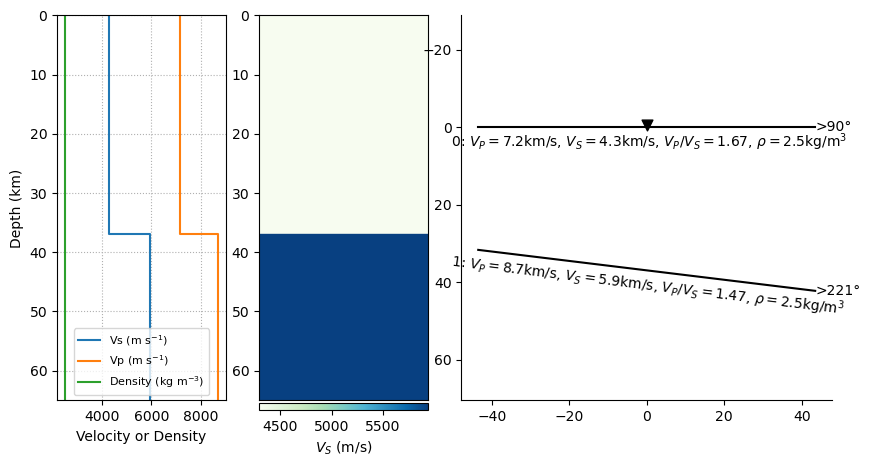

In [187]:
print_and_save(results, station, layers)
# updated model is a global variable
pred_data, model = predict(geom, updated_model)
# !!! for saving the plot, I have changed the prs.py file to return the fig in the plot() function. Also add a keyword argument to the plot() function named "show" to show the plot or not.
fig = model.plot(zmax=65, show=True)
fig.savefig(f"inv/results/{station}_layers_{layers}_updated_model.png")

   index  thickn   rho    vp    vs       dip      strike     plunge  \
0      0   36963  2499  7155  4296  0.000000    0.000000  14.323891   
1      1       0  2488  8694  5933  6.982381  130.521155  22.043387   

        trend       ani  
0  151.129522  8.171475  
1  107.819173  2.930467  


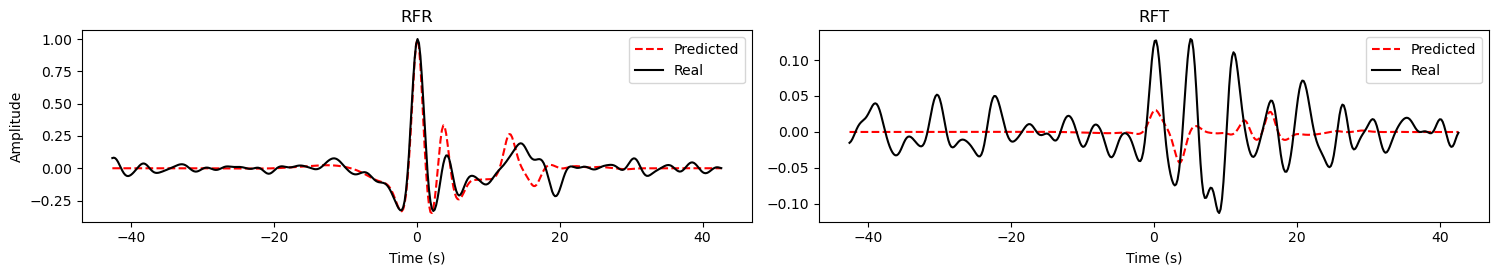

In [188]:
pred_data, model = predict(geom, updated_model)
print(updated_model.head(layers))
pred_stacked = np.mean(pred_data, axis=0)   #stacking the prediction data
obser_stacked = np.mean(obser_data, axis=0) #stacking the observation data
fig = plot_rfr_and_rft(pred_stacked, obser_stacked)
fig.savefig(f"inv/results/{station}_layers_{layers}_rfr_rft.png")

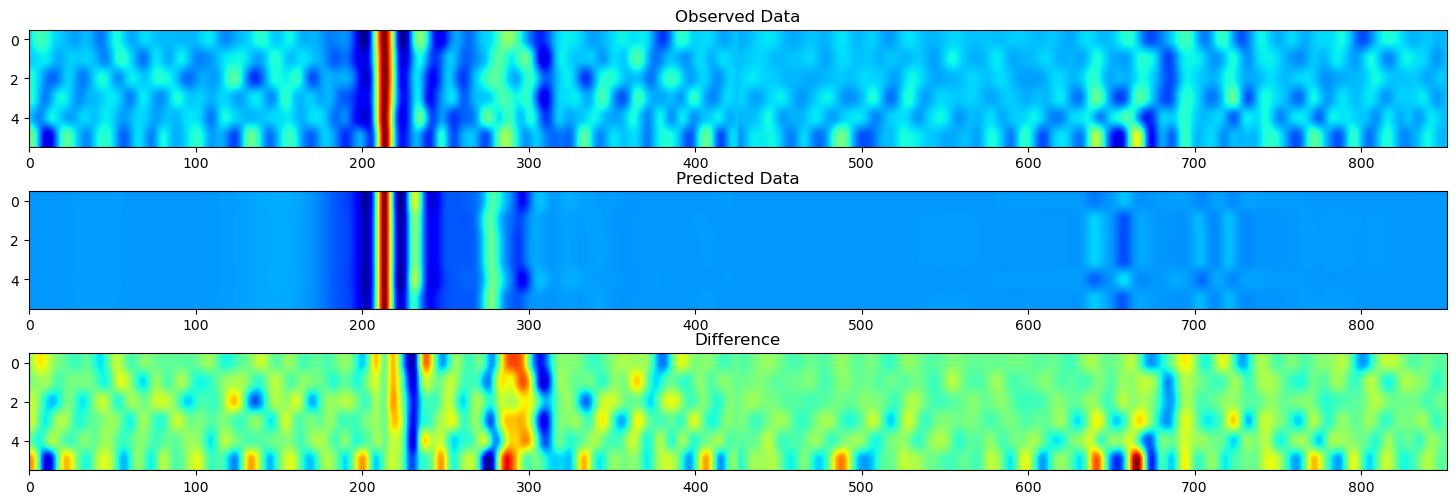

In [189]:
#Matrix visualization
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 5))
fig.tight_layout()
ax[0].imshow(obser_data, aspect="auto", cmap="jet")
ax[0].set_title("Observed Data")
ax[1].imshow(pred_data, aspect="auto", cmap="jet")
ax[1].set_title("Predicted Data")
ax[2].imshow(np.subtract(obser_data, pred_data), aspect="auto", cmap="jet")
ax[2].set_title("Difference")
fig.savefig(f"inv/results/{station}_layers_{layers}_matrix.png")
# fig.colorbar(ax[0].imshow(obser_data, aspect="auto", cmap="jet"), ax=ax[0])



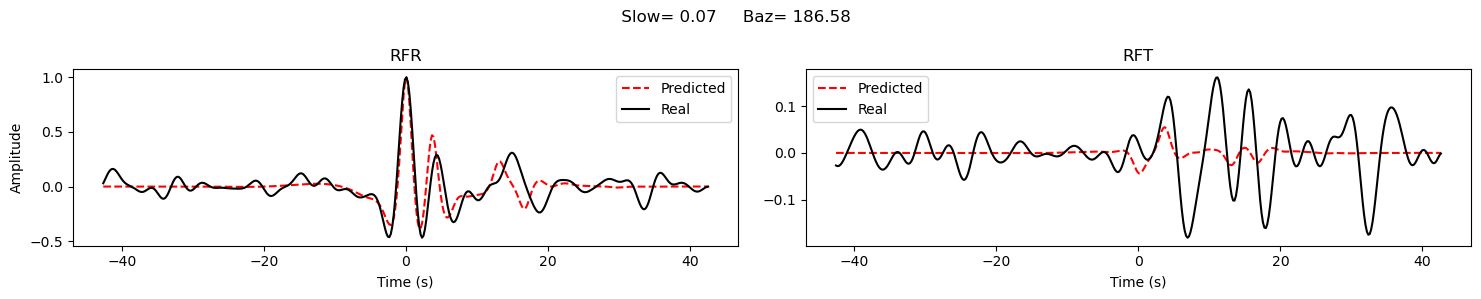

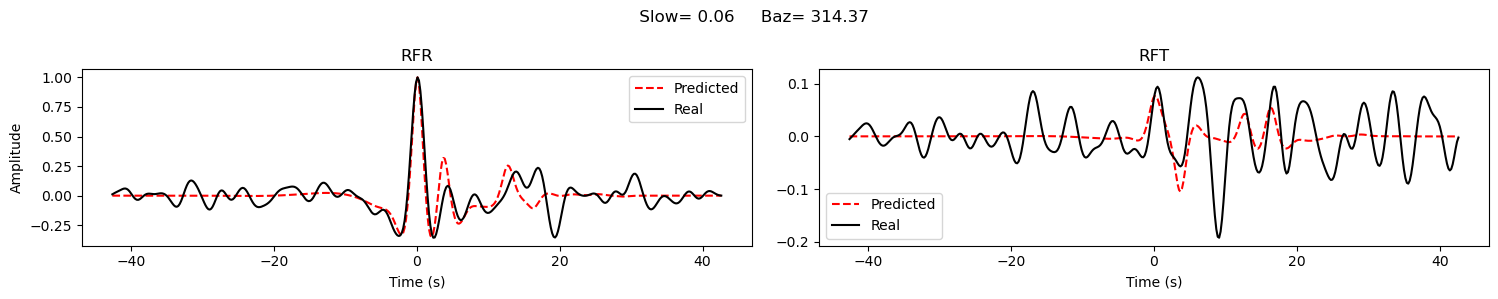

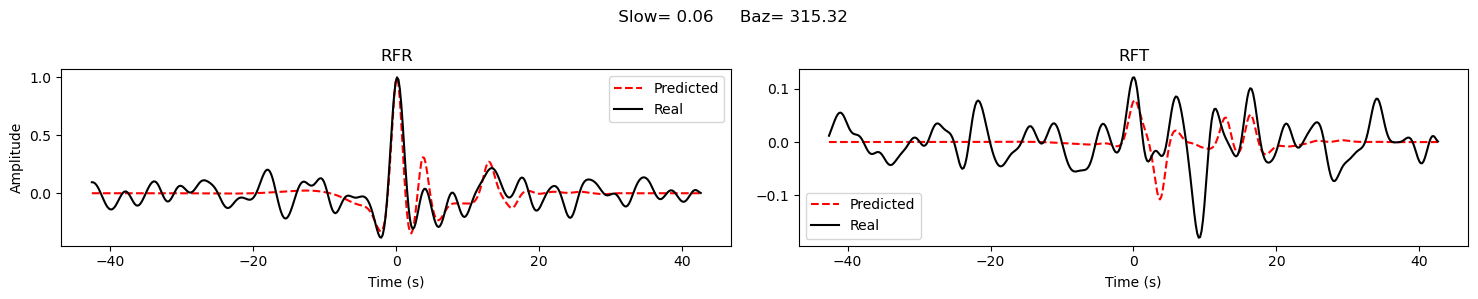

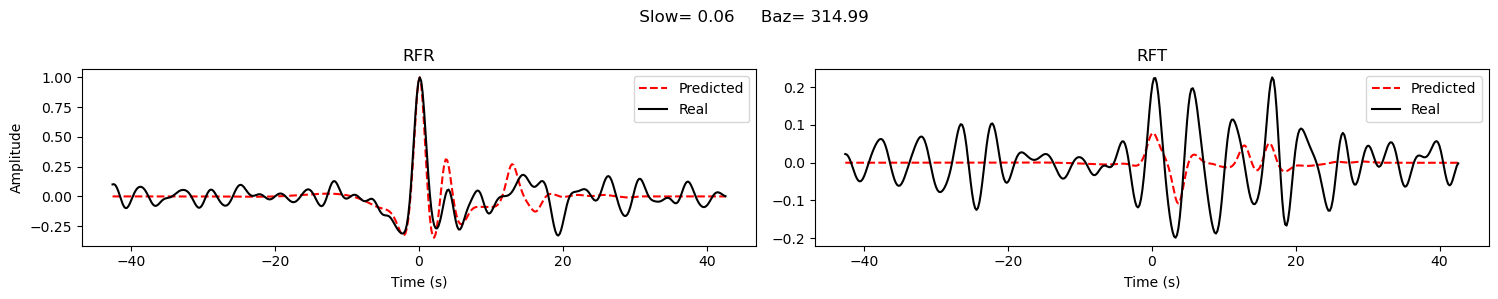

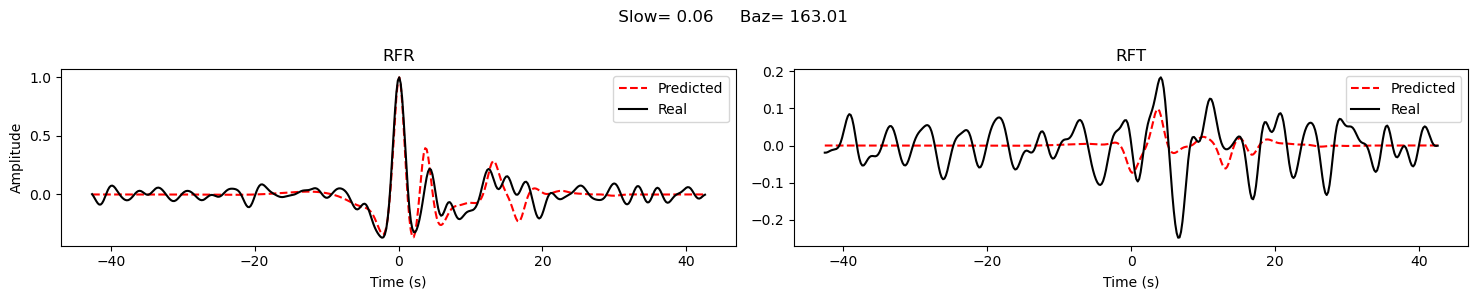

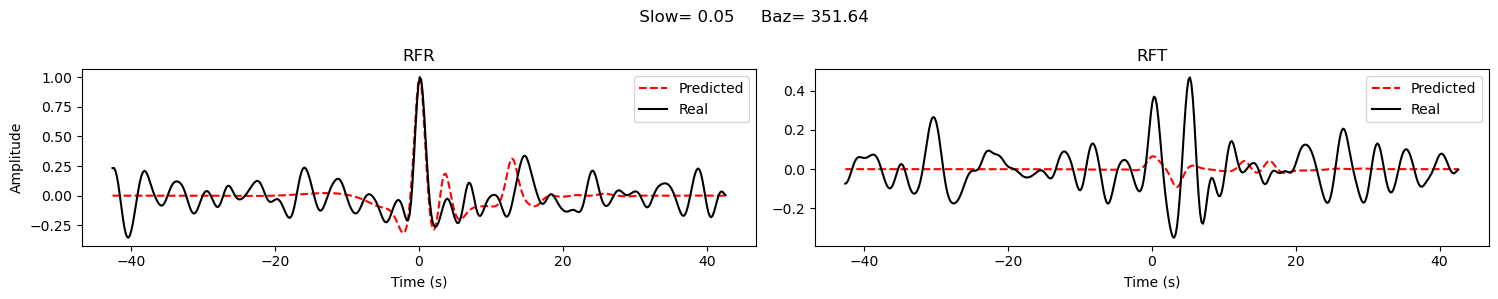

In [190]:
for wave_num in range(len(pred_data)):
    data_pred, _ = predict(geom, updated_model)
    slow_baz = f" Slow= {slow[wave_num]:.2f}     Baz= {baz[wave_num]:.2f} "
    fig = plot_rfr_and_rft(data_pred[wave_num,:], obser_data[wave_num,:], text=slow_baz)
    fig.savefig(f"inv/results/{station}/{station}_layers_{layers}_wave_{wave_num}.png")
